# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Ait Oujkal Abdelltif - __[abdellatif.ait.oujkal@ulb.ac.be](mailto:abdellatif.ait.oujkal@ulb.ac.be) - Student ID 430127__
### Outmane Mouad - __[mouad.outmane@ulb.ac.be](mailto:mouad.outmane@ulb.ac.be) - Student ID 427221__

## Kaggle competition : "INFO-F-422 - Project - 2018-2019"

####  May 31, 2019

# Introduction

The goal of this project is to participate to the "INFO-F-422 - Project - 2018-2019" Kaggle competition and to build a predictive model using some training data that can be downloaded from the Kaggle platform. This training data is composed of 13083 labeled samples and 45 features. The model needs to be able to correctly classify a given testing data. All the provided data has already been normalized so we dont have to care about this step. In order to build the predictive model, we will implement and assess diﬀerent supervised learning algorithms and diﬀerent methods of feature selection and select the ones which appear to be the most accurate and use them for submitting to the Kaggle competition.

# Libraries

This is the set of all the libraries that have been used throughout the project.

In [2]:
library(ggplot2)
library(nnet)
library(devtools)
library(RSNNS)
library(DescTools)
library(rpart)
library(e1071)
library(randomForest)
library(ridge)
library(lazy)
library(glmnet)

### Dataset Analysis

Before starting the implementation of feature selection methods, we import the training data (*"train.csv"*) from the *Kaggle* platform and visualize it to analyze it to determine its dimensions, properties and more.

In [3]:
data <- read.csv("train.csv")

cat("Data set dimensions :", dim(data)[1], " rows and ", dim(data)[2], " columns")

options(warn=-1)
backup_options <- options()

options(repr.matrix.max.cols=12,repr.matrix.max.rows=10)
data
options(backup_options)

Data set dimensions : 13083  rows and  47  columns

id,N1,N2,N3,N4,N5,...,N41,N42,N43,N44,N45,target
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.7574377,-0.6952017,0.032771459,0.0006750661,0.038657370,...,-0.96987381,0.6712369,-0.9754199,-1.8106960,0.1389180,0
6,-0.1886196,-0.3746804,0.003315487,0.0006750667,0.002763647,...,0.07864114,1.1118177,0.5381810,-1.0540006,0.2572848,0
7,-1.1346770,0.8776877,-0.036939470,0.0006750673,-0.042679738,...,0.60289861,-0.8707956,-0.2690728,0.8377381,-0.6896494,0
8,0.7574377,0.9392448,-0.032562221,0.0006750673,-0.035857340,...,0.60289861,2.2132695,1.6145195,0.8377381,1.5198637,0
10,-0.1886196,-0.6697298,0.025036984,0.0006750662,0.033057311,...,0.07864114,-0.8707956,-0.2690728,0.8377381,-0.6896494,0
...,...,...,...,...,...,,...,...,...,...,...,...
39627,0.7574377,-0.63152195,0.005399814,0.0006750662,0.018079436,...,-0.18348760,-0.8707956,-0.2690728,0.8377381,-0.6896494,0
39628,1.7034950,0.69513914,-0.019176244,0.0006750672,0.006849716,...,-0.18348760,0.9095511,-0.7656562,-1.4013926,-0.1071414,0
39633,2.1765237,0.07107777,-0.011916505,0.0006750671,-0.008357064,...,0.07864114,0.6712369,1.6145195,-1.8106960,1.5198637,1


We can see that the training data is composed of 13083 rows representing the labelled samples and 47 colmuns where the first column is non-predictive and represents the id of the sample (*id*), the following 45 are predictive and represent the features (*N_XX* for *XX* from 1 to 45) and the last column is the target and represents the variable to be predicted (*target*). We can see that the target can take two possible values (0 or 1) and therefore we can state that we are confronted with a binary classification problem. In addition, we can observe that all values have been normalized since all features are on the same scale (*double*), so we can skip the normalization step. To summarize, we have **13083** *samples* and **45** *features* among which only the most relevant ones must be kept. Also, we can see that there is no missing values so we dont have to care about them. We will now declare the number of samples and features, remove the *id* column since it is non-predictive and split the independent variables from the dependent variable (*target*).

In [4]:
n.samples <- nrow(data)
n.features <- ncol(data) - 2

X.data <- data[, setdiff(colnames(data), c("id","target"))]
Y.data <- data[, "target"]

We will now plot the histogram of the target variable so that we can see its distribution.

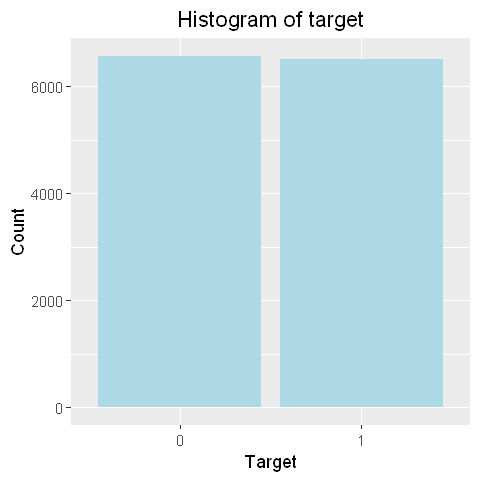

In [5]:
options(repr.plot.width=4, repr.plot.height=4)

df <- as.data.frame(table(Y.data))
df <- setNames(df, c("Target","Count"))
ggplot(df, aes(Target, Count)) + geom_col(fill="lightblue") + ggtitle("Histogram of target") + theme(plot.title = element_text(hjust = 0.5))
options(backup_options)

We can see that we are confronted with a balanced classification problem. In this situation, the predictive model will be less likely to be biased and inaccurate.

In the next section, we will briefly introduce feature selection and talk about its importance and then we will implement some feature selection methods of the three main approaches :  **Filter**, **Wrapper** and **Embedded**.

## Feature Selection

Feature selection seeks to keep only the most relevant features by removing irrelevant features since they can negatively impact model performance. By doing so, we can improve the machine learning model performance such as training time and prediction performance. 

In our case, we have only 45 features but, in general, the dimensions of features are thousands, even millions. 

In this project, we chose to implement and asses a few methods of each approach : Correlation, mRMR, Forward Selection, PCA and Lasso. We assessed each feature selection method on a linear model using 10-fold Cross Validation in order to have a good estimate of the performance. Unfortunately, we wanted to compare the different feature selection methods with more type of models but we did not have enough computational power, it takes a lot of hourse to be executed.

We have defined a function that, given the actual target values and the predicted ones, evaluates the classfication by construction a confusion matrix and returns different metrics such as accuracy, F1 mesure, true postive rates and false positive rates. In addition, we have defined a function which given the results of the feature selection method plots the corresponding graph.

In [6]:
# takes as input the predicted valeus and the true ones, returns the accuracy, F1 score, true positive rate and false positive rate
evaluate_classification <- function(predicted_values, true_values) {
    
    confusion_matrix <- table(true_values, predicted_values)
    
    precision <- confusion_matrix[4] / (confusion_matrix[4] + confusion_matrix[2])
    recall <- confusion_matrix[4] / (confusion_matrix[4] + confusion_matrix[3])
    
    accuracy <- (confusion_matrix[1 ]+ confusion_matrix[4]) / sum(confusion_matrix)
    F1 <- 2*((precision*recall)/(precision+recall))
    TPR <- recall    # Something we want to maximize, How "sensitive" is the classifier to detecting positive instances
    FPR <- confusion_matrix[2] / (confusion_matrix[2] + confusion_matrix[1])        # It decreases by reducing the number of false positive
     
    c(accuracy, F1, TPR, FPR)
}

# takes as input the feature selection method name, the results and the model name.
display_feature_selection_results <- function(feature_selection_name, results, model_name) {
    
    plot(results[,"nFeatures"], results[,"Accuracy"], col="red", type="l", ylim=c(0.5,0.7),
     main=paste("Accuracy vs Features number using ",feature_selection_name),
     xlab="Number of selected features", ylab="Accuracy",axes = FALSE) + grid (45,20, lty = 2, col = "cornsilk2") 
    legend("topright", legend=model_name,inset=c(0,0), col="red", lty=1, cex=0.8, title="Models")
    axis(1, at=seq(from = 1, to = n.features, by = 4))
    axis(2, at=seq(from = 0.5, to = 0.7, by = 0.05), las=1)
    
    plot(results[,"nFeatures"], results[,"F1"], col="red", type="l", ylim=c(0.5,0.7),
     main=paste("F1 vs Features number using ",feature_selection_name),
     xlab="Number of selected features", ylab="F1",axes = FALSE) + grid (45,20, lty = 2, col = "cornsilk2") 
    legend("topright", legend=model_name,inset=c(0,0), col="red", lty=1, cex=0.8, title="Models")
    axis(1, at=seq(from = 1, to = n.features, by = 4))
    axis(2, at=seq(from = 0.5, to = 0.7, by = 0.05), las=1)
}

We define here the number of folds that we will be using during cross validation and create the different folds .

In [7]:
K = 10          # number of folds
folds <- cut(seq(1, n.samples), breaks=K, labels=FALSE)           # create K equally size folds

Let's see now the estimated accuracy of the linear model using 10-fold cross validation and the whole set of features (45).

In [45]:
general_results <- t(data.frame(Accuracy=0, F1=0,TPR=0, FPR=0))

# perform K fold cross validation
for(i in 1:K) {
    
    test_indexes <- which(folds==i,arr.ind=TRUE)
    
    X_test <- X.data[test_indexes,]
    Y_test <- Y.data[test_indexes]
    X_training <- X.data[-test_indexes,]
    Y_training <- Y.data[-test_indexes]
    
    # linear regression
    model <- lm(target~., cbind(X_training,target=Y_training))
    Y_hat <- predict(model,X_test)

    # apply threshold >= 0.5 
    Y_hat <- ifelse(Y_hat >=0.5,1,0)

    general_results <- general_results + evaluate_classification(Y_hat,Y_test)  
}

# average over the k iterations
general_results <- round(general_results/K,digits=4)
general_results

Accuracy,0.6385
F1,0.6309
TPR,0.6444
FPR,0.3648


We can see that using the whole set of features we expect to have on average 63.8% of accuracy. Also, we can notice that the true positive rate is 64,4%, therefore, this model does quite well in identifying actual positives (target=1).

### Correlation


We will now implement a feature selection based on correlation. The idea is that we compute the correlation between the target and each feature. Having a high correlation with the target variable means that they are really related. Therefore, we rank these features in descending order so that the first features are the most correlated. However, we do not know how many features should we selected in order to reduce the number of features while maintaining good accuracy. We will then find the optimal number of features to select by assesing the model with the most correlated variable, the with the two first most correlated variables and so on. We will use 10-fold cross validation in order to have a good estimate of the accuracy.

In [46]:
# compute the correlation with target for each feature
correlation_with_target <- abs(cor(X.data,Y.data))
ranking <- sort(correlation_with_target,decreasing=T,index.return=T)$ix

correlation_results <- data.frame(nFeatures=1:n.features, Accuracy =0,F1=0,TPR=0,FPR=0)

for(i in 1:K){
    test_indexes <- which(folds==i,arr.ind=TRUE)
    
    X_test <- X.data[test_indexes,]
    Y_test <- Y.data[test_indexes]
    X_training <- X.data[-test_indexes,]
    Y_training <- Y.data[-test_indexes]
    
    for(j in 1:n.features){
        
        # train with the first j features of the ranking
        model <- lm(target~., cbind(X_training[,ranking[1:j],drop=F],target=Y_training))
        Y_hat <- predict(model,X_test[,ranking[1:j],drop=F])

        Y_hat <- ifelse(Y_hat >=0.5,1,0)

        correlation_results[j,-1] <- correlation_results[j,-1] + evaluate_classification(Y_hat, Y_test) 
    }
}

correlation_results[,-1] <- round(correlation_results[,-1]/K,digits=4)

cat("\nFeatures ranking using correlation: " , paste(shQuote(ranking), collapse=", "))


Features ranking using correlation:  "20", "27", "24", "6", "11", "29", "18", "26", "35", "31", "25", "19", "8", "28", "30", "32", "43", "45", "23", "22", "42", "12", "38", "2", "21", "14", "34", "33", "10", "37", "16", "36", "7", "1", "13", "4", "3", "44", "5", "17", "39", "9", "40", "41", "15"

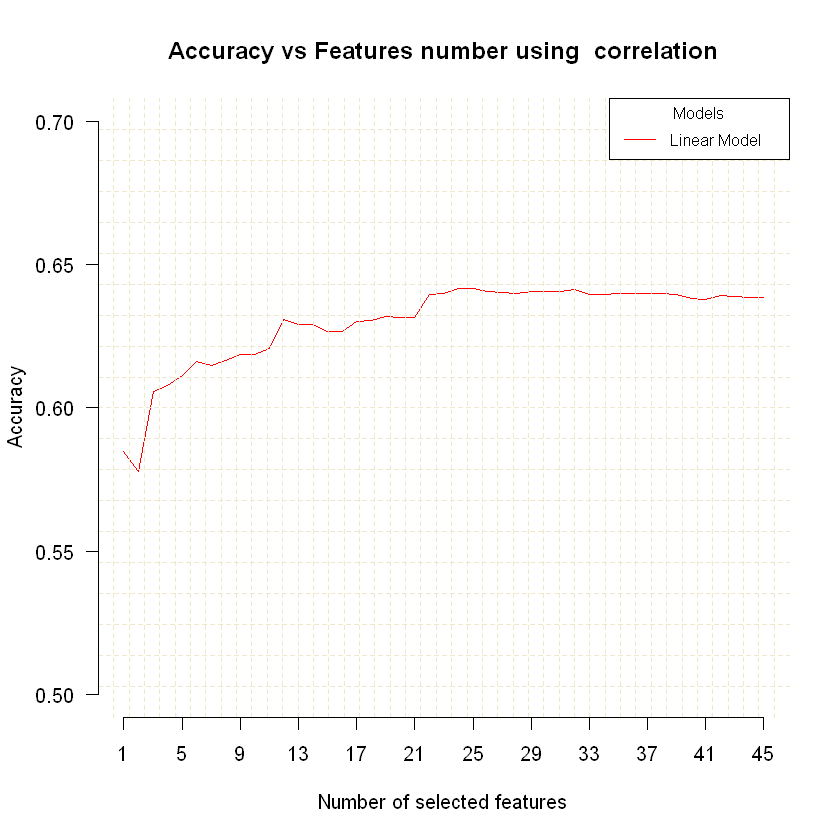

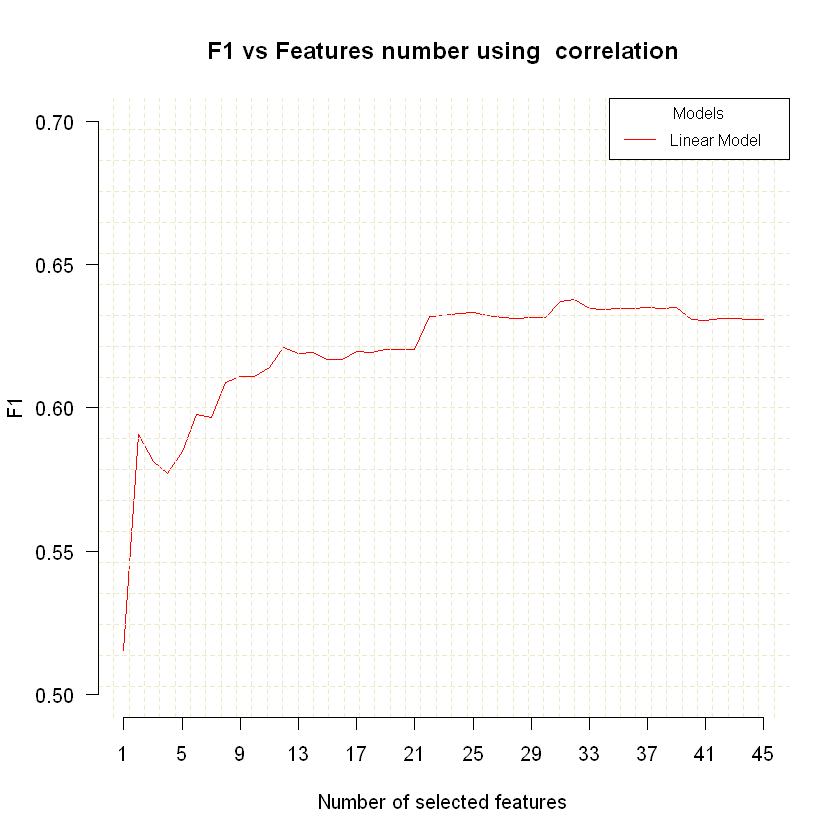

In [47]:
display_feature_selection_results("correlation",correlation_results,"Linear Model")

The graphs above show the performance of the model according to the number of selected features and two different metrics. We can observe that the accuracy and the F1 score is stable untill 22 features are selected. In fact, removing more features will lead to a big drop in accuracy, certainly, it will increase the training time, however, we will end up with a very bad perdictive model. That is why a good compromise between accuracy and execution time must be found. We can conclude that if we select the good features we can have the same results as using the whole set of 45 features but in a optimized way.

### mRMR

We will now implement the mRMR feature selection which is is related to correlation. Indeed, the idea of this method is that we rank the variable by 
taking account not only the correlation with the output but also by avoiding redundant variables. Basically, it ranks the set of features by maximizing the multual information with the target variable and minimizing the average mutual information with all the variables already selected. The set of selected features is initialized with the most relevant feature compared to the target. Then, we add the feature having the highest relevancy with the target and the lowest redundancy with the previously selected features in the set. We repeat this step until all features are selected.

In [48]:
mRMR_results <- data.frame(nFeatures=1:n.features,Accuracy=0,F1=0,TPR=0,FPR=0)

for(i in 1:K){
    test_indexes <- which(folds==i,arr.ind=TRUE)
    
    X_test <- X.data[test_indexes,]
    Y_test <- Y.data[test_indexes]
    X_training <- X.data[-test_indexes,]
    Y_training <- Y.data[-test_indexes]
    
    mRMR_selected_features <- c()
    remaining_features <- 1:n.features
    
    correlation <- abs(cor(X_training,Y_training))                 # compute correlation coefficient between variables x and y (target)
    
    # for each step of feature selection
    for(j in 1:n.features){
        redudancy_score <- rep(0, n.features)
        
        # execute this if it is not the first step of feature selection
        if (length(mRMR_selected_features)>0) {
            cor_sel_rem <- cor(X_training[,mRMR_selected_features,drop=F], X_training[,remaining_features,drop=F])
            redudancy_score <- apply(cor_sel_rem,2,mean)
        }
        mRMR_score <- correlation[remaining_features]-redudancy_score
        
        selected_feature <- remaining_features[which.max(mRMR_score)]           # select feature having the maximum score
        mRMR_selected_features <- c(mRMR_selected_features,selected_feature)              # add the selected feature to the set of selected features
        remaining_features <- setdiff(remaining_features,selected_feature)      # remove the selected feature from the set of remaining features
    
        # build the model with the current set of selected features
        training_data <- cbind(X_training[,mRMR_selected_features,drop=F],target=Y_training)
        model <- lm(target~., training_data)

        Y_hat <- predict(model,X_test[,mRMR_selected_features,drop=F])

        Y_hat <- ifelse(Y_hat >=0.5,1,0)

        mRMR_results[j,-1] <- mRMR_results[j,-1] + evaluate_classification(Y_hat, Y_test)
    }
}

mRMR_results[,-1] <- round(mRMR_results[,-1]/K,digits=4)

cat("\nFeatures ranking using mRMR: " , paste(shQuote(mRMR_selected_features), collapse=", "))


Features ranking using mRMR:  "20", "27", "29", "25", "26", "28", "24", "12", "16", "6", "31", "35", "11", "40", "18", "2", "45", "23", "32", "37", "44", "1", "43", "33", "39", "30", "8", "14", "34", "42", "4", "21", "19", "15", "41", "22", "7", "3", "38", "17", "10", "9", "13", "5", "36"

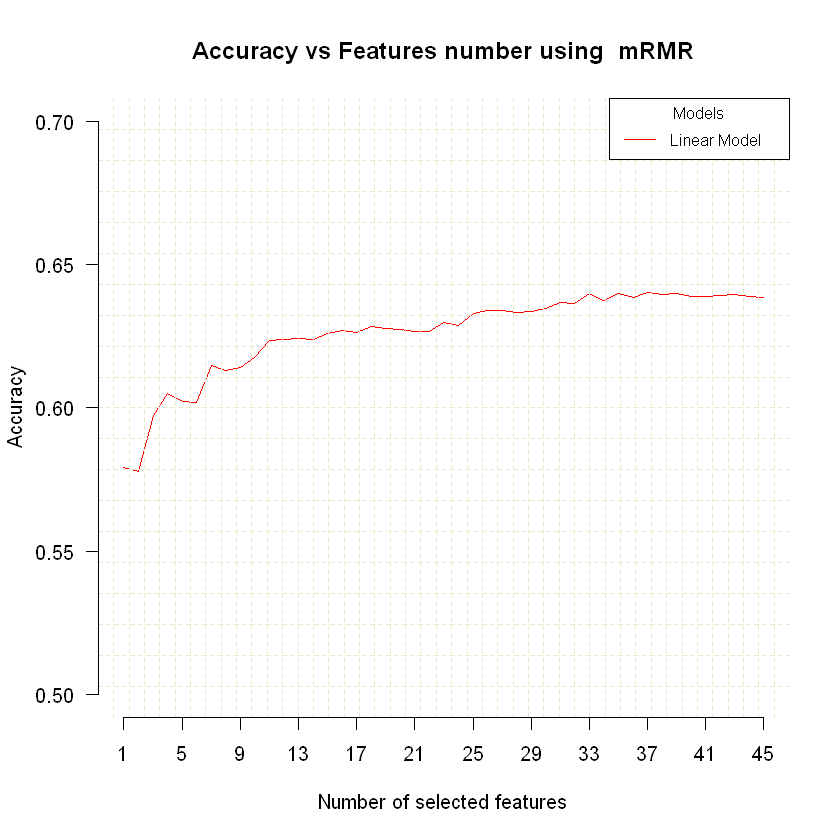

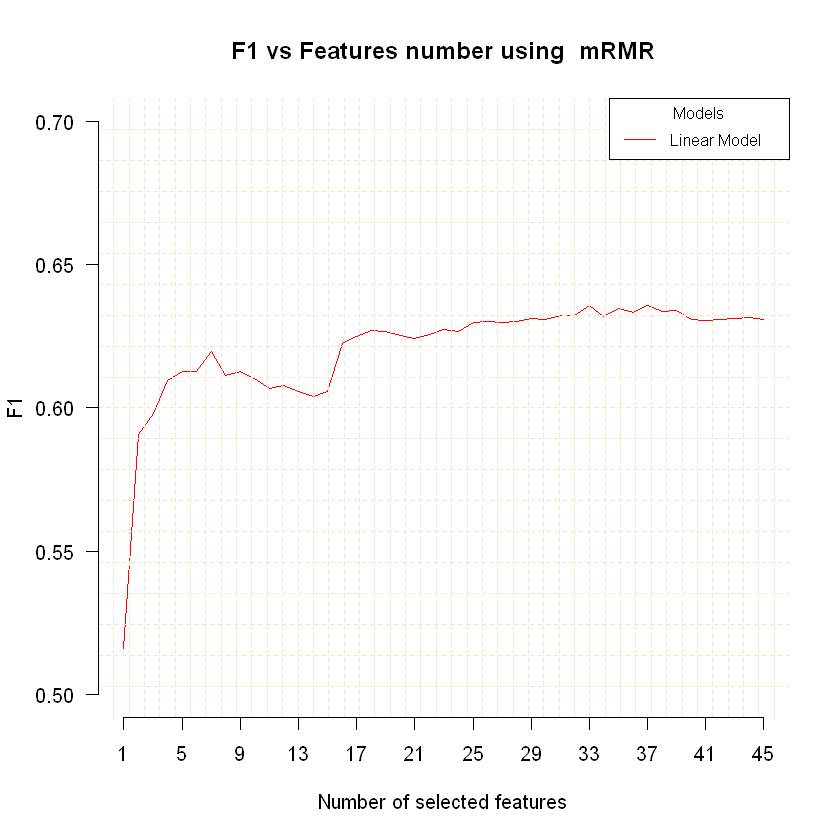

In [49]:
display_feature_selection_results("mRMR",mRMR_results,"Linear Model")

We can see that the ranking is quite similar to the correlation ranking. The two graphs shows that the best set of features is composed of the 25 first features since reducing even more features decreases the accuracy quite a bit.

### Forward Selection

This method is quite different from the two previous one, indeed, it is a greedy search algorithm that attemps to find the optimal feature subset using the model as evaluation. Indeed, at the beginning we have no features then, iteratively, the feature which best improves the model is added. This method is time-consuming but tends to give good results.

In [50]:
FS_results <- data.frame(nFeatures=1:n.features, Accuracy =0,F1=0,TPR=0,FPR=0)

FS_selected_features <- c()
remaining_features <- c(1:n.features)

# for each step of feature selection
for (round in 1:n.features) {
    remaining_features <- setdiff(remaining_features,FS_selected_features)
    results <- data.frame(Accuracy=rep(0, length(remaining_features)),F1=0,TPR=0,FPR=0)

    for (i in 1:length(remaining_features)) {
        subset <- c(FS_selected_features,remaining_features[i])

        for(j in 1:K){
            test_indexes <- which(folds==j,arr.ind=TRUE)

            X_test <- X.data[test_indexes,subset,drop=F]
            Y_test <- Y.data[test_indexes]
            X_training <- X.data[-test_indexes,subset,drop=F]
            Y_training <- Y.data[-test_indexes]

            training_data <- cbind(X_training,target=Y_training)
            model <- lm(target~., training_data)
            Y_hat <- predict(model,X_test)
            
            Y_hat <- ifelse(Y_hat >=0.5,1,0)   
            
            results[i,] <- results[i,] + evaluate_classification(Y_hat, Y_test)
        }
    }
    
    results <- results/K
    best_feature <- which.max(results[,"Accuracy"])
    FS_results[round,-1] <- results[best_feature,]
    
    FS_selected_features<-c(FS_selected_features,remaining_features[best_feature])  
}

cat("\nFeatures ranking using Forward Selection: " , paste(shQuote(FS_selected_features), collapse=", "))


Features ranking using Forward Selection:  "20", "26", "24", "19", "17", "18", "25", "29", "12", "2", "37", "9", "16", "4", "3", "38", "30", "21", "22", "23", "44", "13", "34", "35", "45", "15", "36", "31", "10", "42", "43", "32", "40", "7", "39", "33", "41", "27", "28", "11", "14", "5", "1", "8", "6"

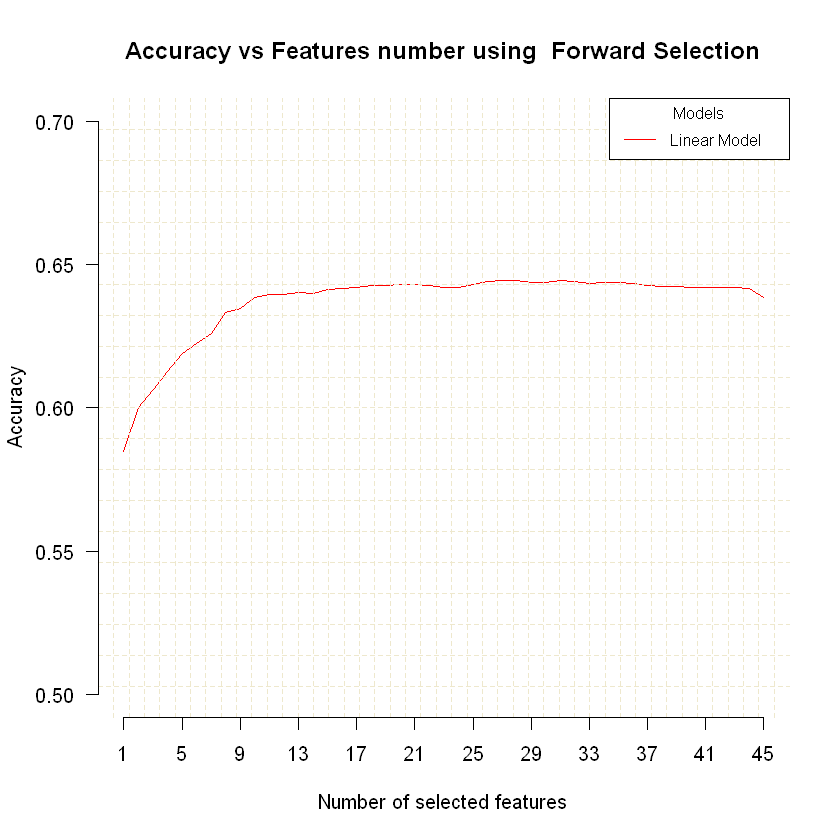

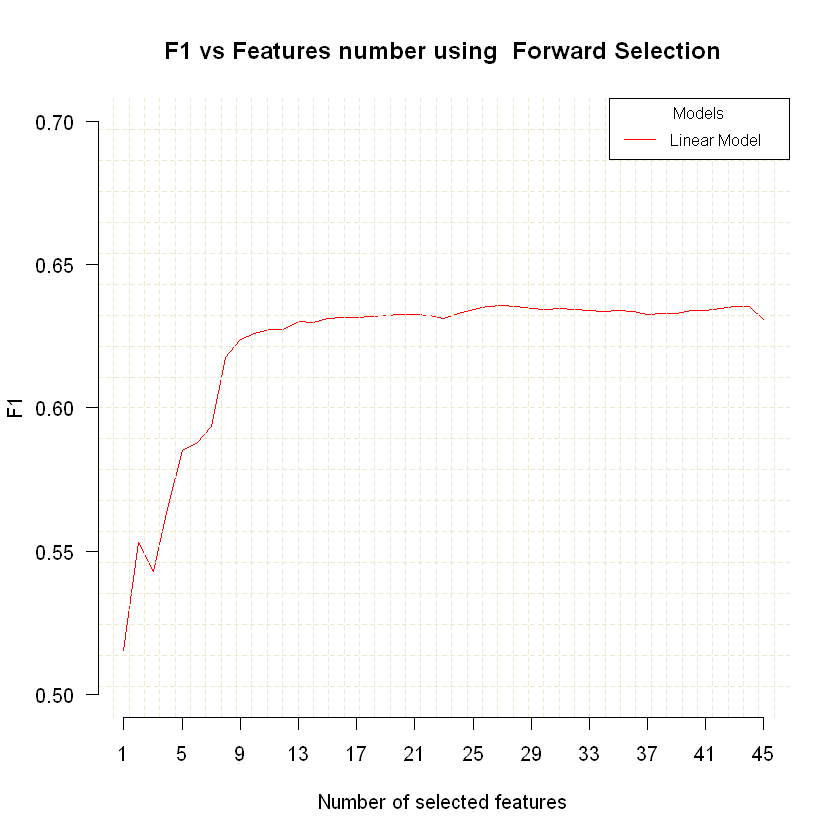

In [51]:
display_feature_selection_results("Forward Selection",FS_results,"Linear Model")

As the graphs above show, the forward selection works very well since the accuracy converges quite quickly when 19 features are selected. We can see that the F1 curve behaves in the same way but when more than 19 characteristics are selected, there is a little more variance than the accuracy curve.

### PCA

PCA is more a feature extraction method than a feature selection method since it consist of transforming the original features into a set of new features that may be more relevant than the original feature. It attempts to ﬁnd a sequence of linear combinations of the features that have maximum variance and are not correlated with each other. These new variables are called Principal Components. We decided to implement this method since it is the most common in the machine learning field and we were curious to see its results. We will plot, according to the number of selcted components, the R2 which tells how much variance is explained.

integer(0)

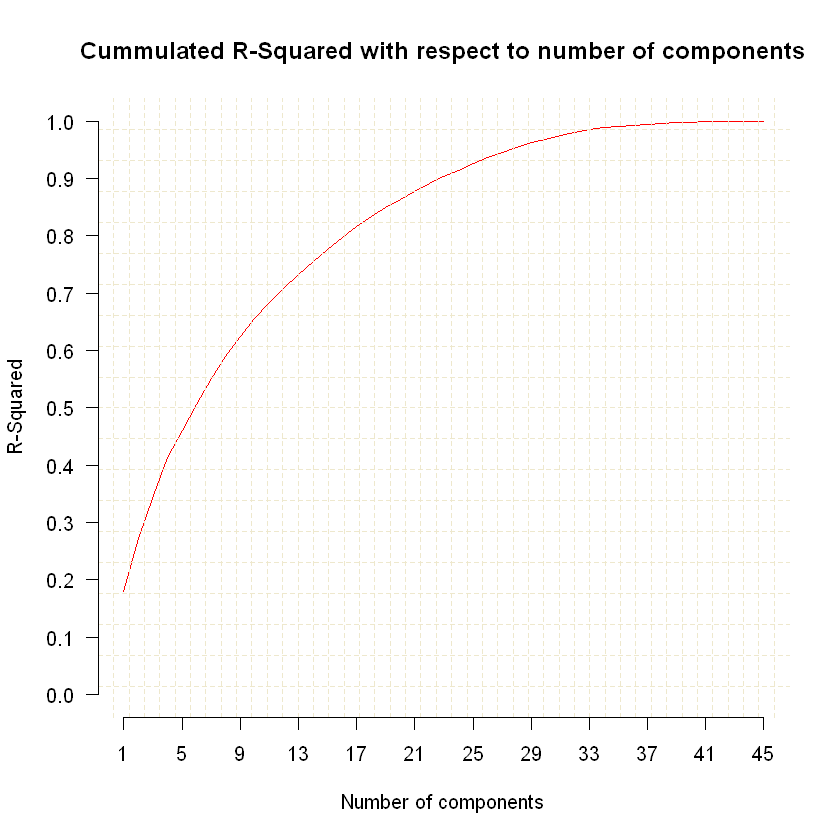

In [52]:
# PCA
pca <- prcomp(X.data,retx=T)

sum = summary(pca)
# plot cummulated R-Squared with respect to number of components
plot(1:n.features,sum$importance[3, ], col="red", type="l", ylim=c(0:1),
     main="Cummulated R-Squared with respect to number of components",
     xlab="Number of components", ylab="R-Squared",axes = FALSE) + grid (45,20, lty = 2, col = "cornsilk2")
axis(1, at=seq(from = 1, to = n.features, by = 4))
axis(2, at=seq(from = 0, to = 1, by = 0.1), las=1)

This graph shows the R-squared values with respect to the number of principle components. It tells us how much of the variance of the original data set can be explained by the new transformed data set. We can see that we do not need the whole components in order to describe the whole variance of the original data set. 25 components are necessary to describe 95% of the original data set’s variance. We will now evaluate PCA.

In [53]:
X.pca <- data.frame(pca$x)

PCA_results <- data.frame(nFeatures=1:n.features,Accuracy=0,F1=0,TPR=0,FPR=0)

for(i in 1:K) {
    test_indexes <- which(folds==i,arr.ind=TRUE)
    
    X_test <- X.pca[test_indexes,]
    Y_test <- Y.data[test_indexes]
    X_training <- X.pca[-test_indexes,]
    Y_training <- Y.data[-test_indexes]

    # for each nb_features first features
    for (nb_features in 1:n.features) {
        model <- lm(target~., cbind(X_training[,1:nb_features,drop=F],target=Y_training))
        Y_hat <- predict(model,X_test[,1:nb_features,drop=F])

        Y_hat <- ifelse(Y_hat >=0.5,1,0)

        PCA_results[nb_features,-1] <- PCA_results[nb_features,-1] + evaluate_classification(Y_hat, Y_test) 
    }
}  

PCA_results[,-1] <- round(PCA_results[,-1]/K,digits=4)

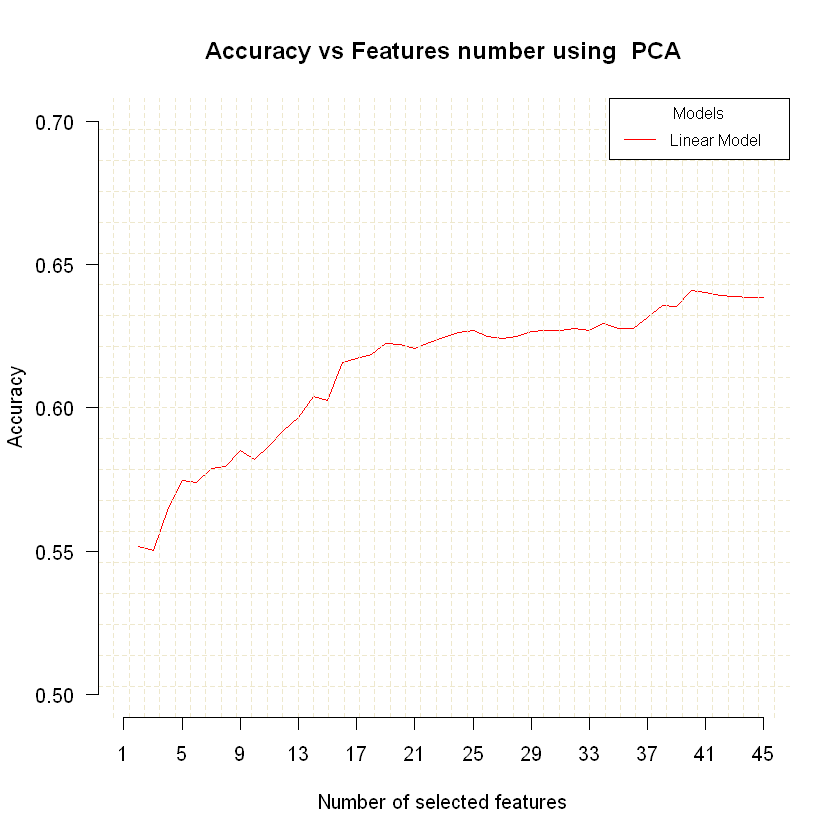

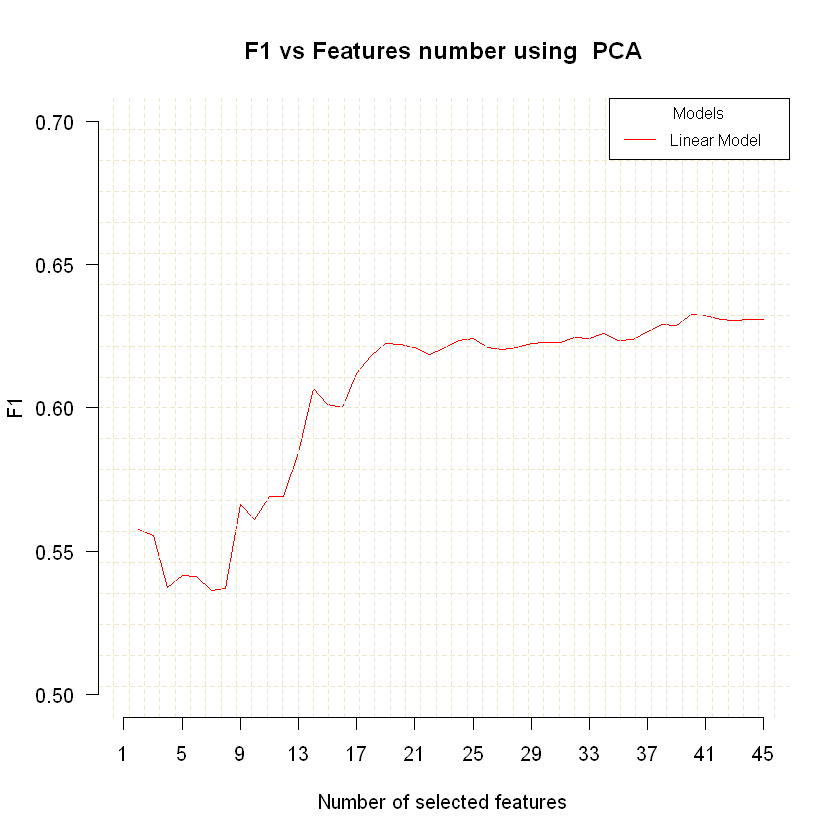

In [54]:
display_feature_selection_results("PCA",PCA_results,"Linear Model")

The accuracy score increases significantly until the the 20th composant, from there the increase is less "steep" but still significant. After the 40th principal component the score does not change much and we reach the maximum accuracy score of 64%. The F1 score curve follows the same behaviour of the accuracy score curve, except that the incraese between the 19th and the 40th principal component is smaller. We can clearly see that the PCA method will not help us a lot at this stage, in fact, we need too much princinpal components (40 out of the 45) to get to a decent accuracy and F1 score.

### Lasso

To decide which variable should be included in the final model we will make use of the powerful LASSO method for variable selection. We have not seen it during the exercice sessions but we have talked about it during lectures. 

In [55]:
# alpha = 1 -> LASSO, alpha=0 -> Ridge Regularization
model <- cv.glmnet (as.matrix(X.data), Y.data, family="binomial",alpha =1)

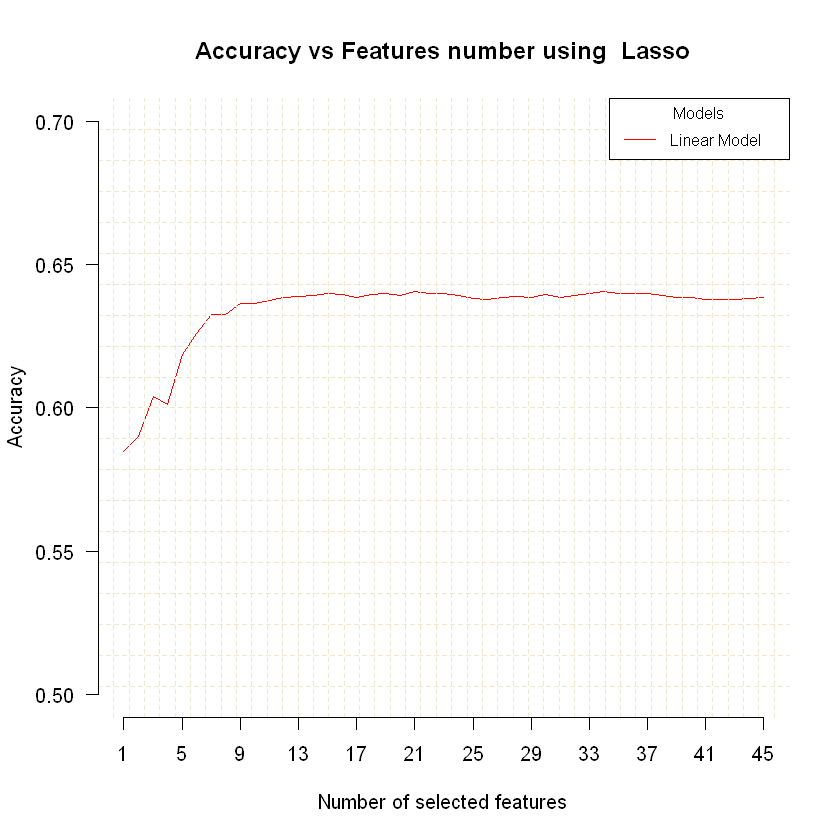

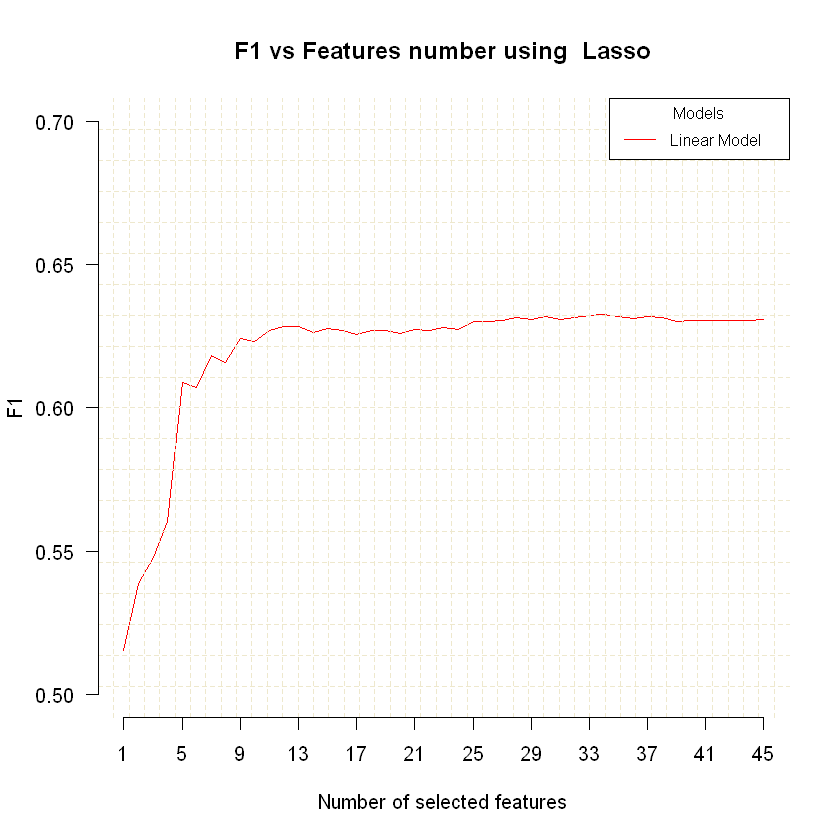

In [56]:
# we find the min lambda, get coefficients and sort by decreasing order
# coefficient equal to 0 means that the variable is not relevant
lasso_ranking <- abs(as.matrix(coef(model, model$lambda.min)))
lasso_ranking = lasso_ranking[-1,]
lasso_ranking_score = as.data.frame(lasso_ranking)[,1]
lasso_ranking = sort.list(lasso_ranking, decreasing = TRUE)

lasso_results <- data.frame(nFeatures=1:n.features, Accuracy =0,F1=0,TPR=0,FPR=0)

for(i in 1:K){
    test_indexes <- which(folds==i,arr.ind=TRUE)
    
    X_test <- X.data[test_indexes,]
    Y_test <- Y.data[test_indexes]
    X_training <- X.data[-test_indexes,]
    Y_training <- Y.data[-test_indexes]
    
    for(j in 1:n.features){
        model <- lm(target~., cbind(X_training[,lasso_ranking[1:j],drop=F],target=Y_training))
        Y_hat <- predict(model,X_test[,lasso_ranking[1:j],drop=F])
        
        Y_hat <- ifelse(Y_hat >=0.5,1,0)

        lasso_results[j,-1] <- lasso_results[j,-1] + evaluate_classification(Y_hat, Y_test) 
    }
}

lasso_results[,-1] <- round(lasso_results[,-1]/K,digits=4)

display_feature_selection_results("Lasso",lasso_results,"Linear Model")

We can see that the Lasso method performs well since from 25 selected features the accuracy do not vary a lot. We will now compare all the feature selection methods and select one among them.

integer(0)

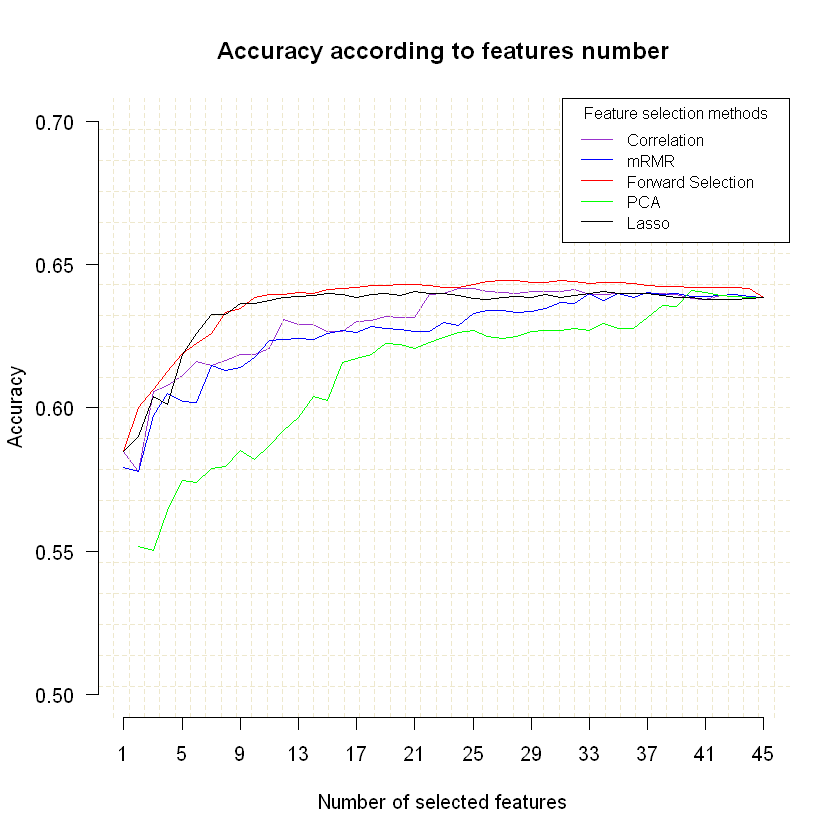

In [57]:
methods = c("Correlation","mRMR","Forward Selection","PCA", "Lasso")
colors = c("darkorchid", "blue", "red", "green","black")

plot(1:n.features, correlation_results[,"Accuracy"], col=colors[1], type="l", ylim=c(0.5,0.7),
 main="Accuracy according to features number",
 xlab="Number of selected features", ylab="Accuracy",axes = FALSE) + grid (45,20, lty = 2, col = "cornsilk2") 
lines(1:n.features,mRMR_results[,"Accuracy"],col=colors[2]) 
lines(1:n.features,FS_results[,"Accuracy"],col=colors[3]) 
lines(1:n.features,PCA_results[,"Accuracy"],col=colors[4])
lines(1:n.features,lasso_results[,"Accuracy"],col=colors[5]) 
legend("topright", legend=methods,inset=c(0,0), col=colors, lty=1, cex=0.8, title="Feature selection methods")
axis(1, at=seq(from = 1, to = n.features, by = 4))
axis(2, at=seq(from = 0.5, to = 0.7, by = 0.05), las=1)

The diagram shows the test accuracy of the different feature selection methods with respect to the number of selected features. It's clear that the worst selection feature method is PCA, it takes 40 principal components to have a score comparable to the models using the other methods. mRMR and correlation are comparable except for the fact that correlation gives features that make the model converge faster. The best method is Forward selection, the only wrapper method we tested. It gives us the best accuracy score and it is the fastest at converging. Taking into consideration the results, we selected the best **25 features** according to the **Forward Selection** method. We have an accuracy score a bit better than the score given by the use of the 45 features, and this with way less features (20). Note that it is not the highest score, the highest score is achieved with 27 features, but the increase is so small that it is not worth to add 7 features.

## Model Selection

Now that we have our set of relevant features, we can start to select our learning model. We will compare many of them and then select three or more models to combine them and hopefully find a strategy to improve our prediction accuracy. The models we chose are **SVM**, **Linear Regression**, **Neural Network**, **Random Forests**, **Decision Tree**,**Nearest Neighbour** and finally **Radial Basis Function Network**. The main metric of comparison will be accuracy and F1 score as we did to evaluate Feature Selection Methods. But this time we will also focus on another metric, the ROC curve and the AUC. Obviously like we did before, we will perform a 10-fold cross validation to have a good estimation of the performance and select the best model. We will also tune the hyperparameters of some models to get the optimal configuration of parameters that lead to better accuracy.

In [58]:
# We define the selected features
features = FS_selected_features[1:25]

### Linear Model

The aim of linear regression is to find a linear relationship between the inputs values and the target classification. This can help us, afterwards, to estimate and classify other inputs.

In [59]:
lm_results <- data.frame(Time=0,Accuracy=0,F1=0,TPR=0,FPR=0)

for(i in 1:K) {
    test_indexes <- which(folds==i,arr.ind=TRUE)

    X_test <- X.data[test_indexes,features,drop=F]
    Y_test <- Y.data[test_indexes]
    X_training <- X.data[-test_indexes,features,drop=F]
    Y_training <- Y.data[-test_indexes]

    start <- proc.time()[["elapsed"]]
    model <- lm(target~., cbind(X_training,target=Y_training))
    Y_hat <- predict(model,X_test)
    lm_results[1] <- lm_results[1] + proc.time()[["elapsed"]] - start

    Y_hat <- ifelse(Y_hat >=0.5,1,0)
    
    lm_results[-1] <- lm_results[-1] + evaluate_classification(Y_hat, Y_test) 
}  

lm_results <- round(lm_results/K,digits=4)

In [60]:
t(lm_results)

Time,0.0140
Accuracy,0.6430
F1,0.6326
TPR,0.6488
FPR,0.3637


In linear regression we have no hyperparamter to tune. We just executed the 10-fold cross validation process with a simple linear model and the selected features. We can see that the training time is really fast and that the accuracy is quite good too 64,8%.

### SVM

SVM also called Support Vector Machine, is a supervised learning method that can do both classification and regression. SVM can perform a linear regression aswell a non-linear classification using the kernel trick. Basically, it tries to build hyperplanes maximizing the margin (the distance between the hyperplane and the nearest data point). In order to evaluate the model we will try to test different kernels (linear, polynomial, radial basis function, sigmoid function) and see which one leads to a better accuracy.

In [61]:
kernels <- c("linear","radial","poly","sigmoid")

svm_results <- data.frame(Kernel=kernels,Time=0,Accuracy=0,F1=0,TPR=0,FPR=0)

for(i in 1:length(kernels)){
    for(j in 1:K){
        test_indexes <- which(folds==j,arr.ind=TRUE)

        X_test <- X.data[test_indexes,features]
        Y_test <- Y.data[test_indexes]
        X_training <- X.data[-test_indexes,features]
        Y_training<- Y.data[-test_indexes]

        start <- proc.time()[["elapsed"]]
        model <- svm(target~.,data=cbind(X_training,target=Y_training), kernel=kernels[i])
        Y_hat <- predict(model,X_test)
        svm_results[2] <- svm_results[2] + proc.time()[["elapsed"]] - start

        Y_hat <- ifelse(Y_hat >=0.5,1,0)

        svm_results[-c(1:2)] <- svm_results[-c(1:2)] + evaluate_classification(Y_hat, Y_test)
    }
    
    svm_results[-1] <- round(svm_results[-1]/K,digits=4)
}

In [62]:
svm_results
cat("Best kernel :")
svm_results <- svm_results[which.max(svm_results$Accuracy),]
svm_results

Kernel,Time,Accuracy,F1,TPR,FPR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
linear,25.9489,0.5738,0.5738,0.5738,0.5738
radial,25.9489,0.5728,0.5728,0.5728,0.5728
poly,25.9489,0.5713,0.5713,0.5713,0.5713
sigmoid,25.9489,0.5425,0.5425,0.5425,0.5425


Best kernel :

Kernel,Time,Accuracy,F1,TPR,FPR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
linear,25.9489,0.5738,0.5738,0.5738,0.5738


We can see that the best kernel which gave the best accuracy is the linear kernel. Since the difference time execution between the linear and radial kernel is negligeable, we chose to select the linear kernel and win 0.001 accuracy.

### Nearest Neighbour

The Nearest Neighbour is a method of classification and regression. We have no hyperparameters to tune so we just perform a 10-fold cross validation and estimate the accuracy.

In [63]:
lazy_results <- data.frame(Time=0, Accuracy=0,F1=0,TPR=0,FPR=0)

for(i in 1:K){
    test_indexes <- which(folds==i,arr.ind=TRUE)
    
    X_test <- X.data[test_indexes,features]
    Y_test <- Y.data[test_indexes]
    X_training <- X.data[-test_indexes,features]
    Y_training<- Y.data[-test_indexes]

    start <- proc.time()[["elapsed"]]
    model <- lazy(target~., cbind(X_training,target=Y_training))
    Y_hat <- unlist(predict(model,X_test))
    lazy_results[1] <- lazy_results[1] + proc.time()[["elapsed"]] - start

    Y_hat <- ifelse(Y_hat >=0.5,1,0)
    
    lazy_results[-1] <- lazy_results[-1] + evaluate_classification(Y_hat, Y_test) 
}

lazy_results <- round(lazy_results/K,digits=4)

In [64]:
t(lazy_results)

Time,3.0180
Accuracy,0.6013
F1,0.5903
TPR,0.6040
FPR,0.4057


We obtained an accuracy of 60% which is less that the two previous models.

### Decision Trees

The Decision tree model consist of building a decision tree during the training process where the conditions on the internals nodes are defined by the features of the input data set. By setting up the tree, the model can classify new inputs by going through the tree from the top to the leaf. We have no hyperparameters to tune for this model so we will just perform a 10-fols cross validation.

In [65]:
tree_results <- data.frame(Time=0,Accuracy=0,F1=0,TPR=0,FPR=0)

for(i in 1:K){
    test_indexes <- which(folds==i,arr.ind=TRUE)
    
    X_test <- X.data[test_indexes,features]
    Y_test <- Y.data[test_indexes]
    X_training <- X.data[-test_indexes,features]
    Y_training<- Y.data[-test_indexes]
    
    training_data <- cbind(X_training,target=Y_training)
    
    start <- proc.time()[["elapsed"]]
    model <- rpart(target~., training_data)
    
    options(warn=-1)
    Y_hat <- predict(model,X_test)
    options(warn=1)
    tree_results[1] <- tree_results[1] + proc.time()[["elapsed"]] - start

    Y_hat <- ifelse(Y_hat >=0.5,1,0)
    
    tree_results[-1] <- tree_results[-1] + evaluate_classification(Y_hat, Y_test) 
}

tree_results <- round(tree_results/K,digits=4)

In [66]:
t(tree_results)

Time,0.4760
Accuracy,0.5955
F1,0.6173
TPR,0.5830
FPR,0.3724


As we can see, decision tree perform bad compared to the previous models we have seen.

### Random Forests

Random Forest consits of many decision trees that train on the same train set and whenever a classification need to be made, the majority vote is returned as the predicted value. The hyperparameter that we tune here is the number of trees. In fact, Larger the tree, it will be more computationally expensive to build models, so we need to find a good trade-off.

In [67]:
n_trees = c(50,100,250,500)

rf_results <- data.frame(NbTrees=n_trees,Time=0,Accuracy=0,F1=0,TPR=0,FPR=0)

for (i in 1:length(n_trees)){
    for(j in 1:K){
        test_indexes <- which(folds==j,arr.ind=TRUE)

        X_test <- X.data[test_indexes,features]
        Y_test <- Y.data[test_indexes]
        X_training <- X.data[-test_indexes,features]
        Y_training<- Y.data[-test_indexes]
        
        start <- proc.time()[["elapsed"]]
        model <- randomForest(X_training, as.factor(Y_training), ntree=n_trees[i])
        Y_hat <- predict(model,X_test)
        rf_results[i,2] <- rf_results[i,2] + proc.time()[["elapsed"]] - start

        rf_results[i,-c(1:2)] <- rf_results[i,-c(1:2)] + evaluate_classification(Y_hat, Y_test)
    }

    rf_results[i,-1] <- round(rf_results[i,-1]/K,digits=4)
}

In [68]:
rf_results
cat("Best number of trees :")
rf_results <- rf_results[which.max(rf_results$Accuracy),]
rf_results

NbTrees,Time,Accuracy,F1,TPR,FPR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
50,1.461,0.6344,0.6303,0.6339,0.3680
100,2.903,0.6382,0.6364,0.6374,0.3643
250,7.188,0.6421,0.6393,0.6410,0.3597
500,14.150,0.6438,0.6410,0.6419,0.3563


Best number of trees :

,NbTrees,Time,Accuracy,F1,TPR,FPR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,500,14.15,0.6438,0.641,0.6419,0.3563


We can see that the best number of trees that has been found is 500 and gives an accuracy of 64.4% which is the highest till now.

### Neural Networks

Neural network are network of nodes (neuron) that try to imitate what happens with in biological brains with the neurons. The model is structured this way: First there is an input layer, then there are one or more hidden layers (in our case just one) and finally there is an output layer. The layers are connected between them and can have a certain quantity of nodes. Between two nodes the connection has a certain weigth. The weighs are update during the training process of the network and they are responsible of the good performance of the network. 

Neural networks have many hyperparameters to tune: The **size** of the hidden layer (number of nodes of the layer), the maximum **number of iterations** and the **rang** (the value that gives the interval [-rang, rang] wich will be used for initializing weights values).

In [69]:
sizes = c(2, 7,15)
maxit = c(50,100,150)
rangs = c(0.1,0.5,1)

combinations <- expand.grid(sizes,maxit,rangs)

nnet_results <- data.frame(Size=combinations[,1],MaxIt=combinations[,2],Rang=combinations[,3],Time=0,Accuracy=0,F1=0,TPR=0,FPR=0)

for(row in 1:nrow(combinations)){
    for(i in 1:K){
        test_indexes <- which(folds==i,arr.ind=TRUE)

        X_test <- X.data[test_indexes,features]
        Y_test <- Y.data[test_indexes]
        X_training <- X.data[-test_indexes,features]
        Y_training<- Y.data[-test_indexes]

        params <- as.numeric(combinations[row,])
        
        start <- proc.time()[["elapsed"]]
        model <- nnet(target~., data=cbind(X_training,target=Y_training), trace=F,size=params[1],maxit=params[2],rang=params[3])
        Y_hat <- predict(model,X_test)
        nnet_results[i,4] <- nnet_results[i,4] + proc.time()[["elapsed"]] - start

        Y_hat <- ifelse(Y_hat >=0.5,1,0)

        nnet_results[row,-c(1:4)] <- nnet_results[row,-c(1:4)] + evaluate_classification(Y_hat, Y_test)
    }
    
    nnet_results[row,-c(1:3)] <- round(nnet_results[row,-c(1:3)]/K,digits=4)
}

In [70]:
nnet_results
cat("Best size, maxit and rang :")
nnet_results <- nnet_results[which.max(nnet_results$Accuracy),]
nnet_results

Size,MaxIt,Rang,Time,Accuracy,F1,TPR,FPR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,50,0.1,78.598,0.6419,0.6525,0.6357,0.3505
7,50,0.1,75.733,0.6398,0.6277,0.6456,0.3673
15,50,0.1,73.385,0.6372,0.6333,0.6424,0.3687
2,100,0.1,73.734,0.6391,0.6346,0.6388,0.3634
7,100,0.1,71.143,0.6415,0.6325,0.6446,0.3626
15,100,0.1,65.645,0.6314,0.6210,0.6360,0.3751
2,150,0.1,64.353,0.6387,0.6375,0.6381,0.3568
7,150,0.1,59.803,0.6324,0.6308,0.6329,0.3710
15,150,0.1,52.378,0.6184,0.6108,0.6186,0.3842


Best size, maxit and rang :

Size,MaxIt,Rang,Time,Accuracy,F1,TPR,FPR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,50,0.1,78.598,0.6419,0.6525,0.6357,0.3505


The best accuracy that was found is given by the combinations of 2 hidden nodes, 50 maximum iteration and 0.1 value for rang. We have an accuracy of 64.3% which is close to the accuracy of random forest and linear model.

### Radial Basis Function Network

A RBF Network is basically a Neural Network but as a activation function, it has a Radial Basis Function. An activation function is simply the function that will define the ouput of a node given a certain input.

Here we have to tune two parameters **max_iterations** and **linOuts**. The first one corresponds to the number of maximum iterations and the second one sets the activation function of outpus nodes to linear or logistic.

In [71]:
max_iterations <- c(10,20,40,60,80,100,150)
linOuts <- c(0,1)

combinations <- expand.grid(max_iterations,linOuts)

rbf_results <- data.frame( MaxIt=combinations[,1],linOut=combinations[,2],Time=0,Accuracy=0,F1=0,TPR=0,FPR=0)

for(row in 1:nrow(combinations)){
    for(i in 1:K){
        test_indexes <- which(folds==i,arr.ind=TRUE)

        X_test <- X.data[test_indexes,features]
        Y_test <- Y.data[test_indexes]
        X_training <- X.data[-test_indexes,features]
        Y_training<- Y.data[-test_indexes]

        params <- combinations[row,]
        
        start <- proc.time()[["elapsed"]]
        model <- rbf(X_training,Y_training, maxit=params[[1]],linOut=params[[2]])
        Y_hat <- predict(model,X_test)
        rbf_results[i,3] <- rbf_results[i,3] + proc.time()[["elapsed"]] - start

        Y_hat <- ifelse(Y_hat >=0.5,1,0)

        rbf_results[row,-c(1:3)] <- rbf_results[row,-c(1:3)] + evaluate_classification(Y_hat, Y_test) 
    }
    
    rbf_results[row,-c(1:3)] <- round(rbf_results[row,-c(1:3)]/K,digits=4)
}

In [72]:
rbf_results
cat("Best maxit and linout :")
rbf_results <- rbf_results[which.max(rbf_results$Accuracy),]
rbf_results

MaxIt,linOut,Time,Accuracy,F1,TPR,FPR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,0,30.38,NA,NA,NA,0.4977
20,0,30.22,NA,NA,NA,0.3698
40,0,30.10,0.5810,0.5297,0.6056,0.3819
60,0,30.33,0.5791,0.5197,0.6061,0.3853
80,0,29.94,0.5790,0.5196,0.6062,0.3853
100,0,30.06,0.5795,0.5207,0.6065,0.3848
150,0,30.14,0.5803,0.5232,0.6070,0.3839
10,1,29.87,0.5927,0.5781,0.5982,0.3925
20,1,30.36,0.5927,0.5780,0.5983,0.3949


Best maxit and linout :

,MaxIt,linOut,Time,Accuracy,F1,TPR,FPR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,80,1,0,0.595,0.5814,0.6005,0.3913


As we can see, using Radial Basis Function is not that good since we have an accuracy of 59,4% with the best parameters which is less than the previous models.

### Comparaison

We have now tuned all the models that could be tuned and evaluated them all. We will plot all the results in a unique graph so that it can be easier to interpret the results.

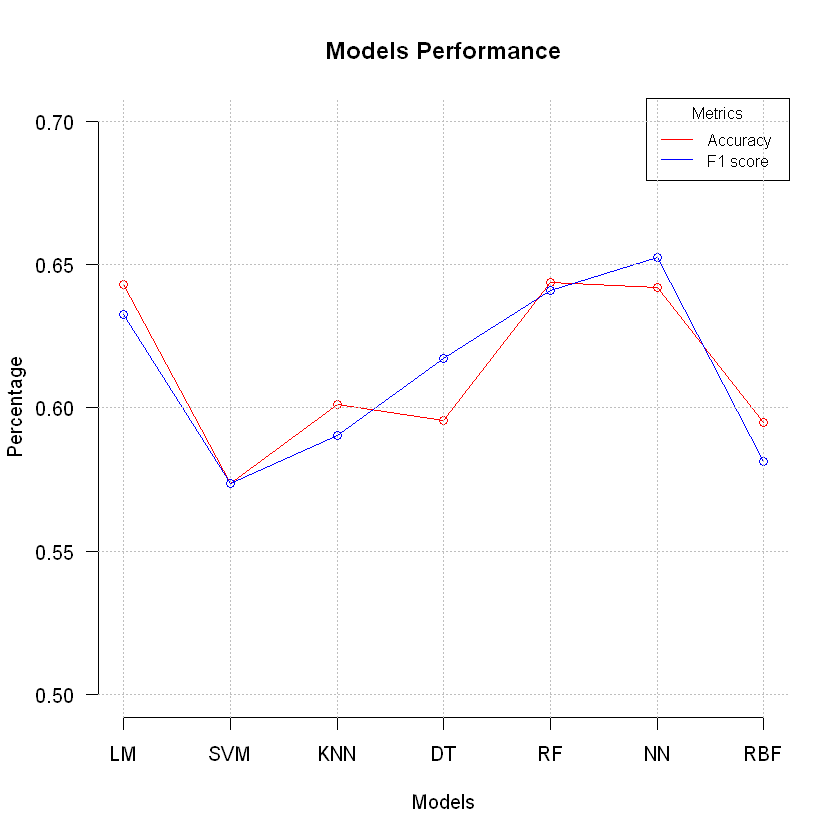

In [73]:
models <- c("LM", "SVM", "KNN","DT","RF","NN","RBF")
colors <- c("red","blue")

# Basic plot
x <- c(1:length(models))
acc <- c(lm_results["Accuracy"],svm_results["Accuracy"],lazy_results["Accuracy"],tree_results["Accuracy"],
       rf_results["Accuracy"],nnet_results["Accuracy"],rbf_results["Accuracy"])

f1 <- c(lm_results["F1"],svm_results["F1"],lazy_results["F1"],tree_results["F1"],
       rf_results["F1"],nnet_results["F1"],rbf_results["F1"])

plot(x, acc, col=colors[1], type="o", ylim=c(0.5,0.7),main="Models Performance", 
ylab="Percentage", xlab="Models",axes = FALSE)
lines(x,f1,col=colors[2], type="o") 
legend("topright", legend=c("Accuracy","F1 score"),inset=c(0,0), col=colors, lty=1, cex=0.8, title="Metrics")
axis(1, at=seq(from = 1, to = length(models), by = 1), labels=models)
axis(2, at=seq(from = 0.5, to = 0.7, by = 0.05), las=1)
abline(h=seq(from = 0, to = 1, by = 0.05), v=1:length(models), col="gray", lty=3)

In this plot we are comparing the accuracy and the F1 score of the 7 learning models. We can see that the F1 score is always near to the accuracy score except for the decision tree.

The best models are the linear regression, the random forests and the neural network. The Random forest is the best one, it has the best accuracy score and F1 score, this means that it has a good ratio of precision and recall. The best three models will be chosen to make a combination and hopefully improve accuracy.

One know metric for evaluation binary classification is the ROC curve which evaluates the performance of the classifier at various thresholds. The AUC (Area Under the Curve) is the total area under the ROC curve, it can tell how much good a classifier is at detecting TP and TN. The higher is the AUC, the better is the model at distinguishing classes. We will compute it for all tuned models and see which results do we get.

In [10]:
# computes true positive rate
compute_tpr <- function(predicted_values, correct_values) {
    confusion_matrix <- table(predicted_values, correct_values)
    
    if(dim(confusion_matrix)[1]==1){
        if(predicted_values[1] == 0){
            return(0)
        }
        else{
            return (1)
        }
    }
    else{
        tp <- confusion_matrix['1','1']
        fn <- confusion_matrix['0','1']
        return (tp / (tp + fn))
    }
}

# computes false positive rate
compute_fpr <- function(predicted_values, correct_values) {
    
    confusion_matrix <- table(predicted_values,correct_values)
    if(dim(confusion_matrix)[1]==1){
        if(predicted_values[1] == 0){
            return(0)
        }
        else{
            return(1)
        }
    }
    else{
        tn <- confusion_matrix['0','0']
        fp <- confusion_matrix['1','0']
        return (fp / (fp + tn))
    }
}

# computes the ROC curves
compute_rocs <- function(Y_hats, Y_tests) {
    threshold = seq(-0.1,1.1,0.1)
    
    tprs_folds = matrix(0,length(Y_hats),length(threshold))
    fprs_folds = matrix(0,length(Y_hats),length(threshold))
    
    mean_roc_x = list()
    mean_roc_y = list()

    for(p in 1:length(Y_hats)){
        tprs = rep(0,length(threshold))
        fprs = rep(0,length(threshold))
        for(i in 1:length(threshold)){
            Y_hat1 <- ifelse((Y_hats[[p]]) >= threshold[i],1,0) 
            tpr = compute_tpr(Y_hat1, Y_tests[[p]])
            fpr = compute_fpr(Y_hat1, Y_tests[[p]])
            tprs[i] = tpr
            fprs[i] = fpr
        }
        tprs_folds[p,] = tprs
        fprs_folds[p,] = fprs
    }
    
    for(i in 1:length(threshold)){
        mean_roc_x[[i]] = mean(tprs_folds[,i])
        mean_roc_y[[i]] = mean(fprs_folds[,i])
    }
    
    tpr_fpr =list("tpr" = mean_roc_x, "fpr" = mean_roc_y)
    
    return(tpr_fpr)
}

In [8]:
predictions1 = list()
predictions2 = list()
predictions3 = list()
predictions4 = list()
predictions5 = list()
predictions6 = list()
predictions7 = list()

Y_tests = list()

for(i in 1:5){
    test_indexes <- which(folds==i,arr.ind=TRUE)
    
    X_test <- X.data[test_indexes,]
    Y_test <- Y.data[test_indexes]
    
    Y_tests[[i]] = Y_test    # we need it after for computing the roc curve
    
    X_training <- X.data[-test_indexes,]
    Y_training <- Y.data[-test_indexes]
    # train the models
    model1 <- lm(target~., data=cbind(X_training,target=Y_training))
    model2 <- svm(target~., data=cbind(X_training,target=Y_training))
    model3 <- nnet(target~., data=cbind(X_training,target=Y_training), trace=F,size=2,maxit=50,rang=0.1)
    model4 <- randomForest(X_training, Y_training, ntree=500)
    model5 <- lazy(target~., cbind(X_training,target=Y_training))
    model6 <- rbf(X_training,Y_training, maxit=80,linOut=1)
    model7 <- rpart(target~., cbind(X_training,target=Y_training))
    # make predictions
    predictions1[[i]] <- predict(model1,X_test)
    predictions2[[i]] <- predict(model2,X_test)
    predictions3[[i]] <- predict(model3,X_test)
    predictions4[[i]] <- predict(model4,X_test)
    predictions5[[i]] <- unlist(predict(model5,X_test))
    predictions6[[i]] <- predict(model6,X_test)
    predictions7[[i]] <- predict(model7,X_test)
}

integer(0)

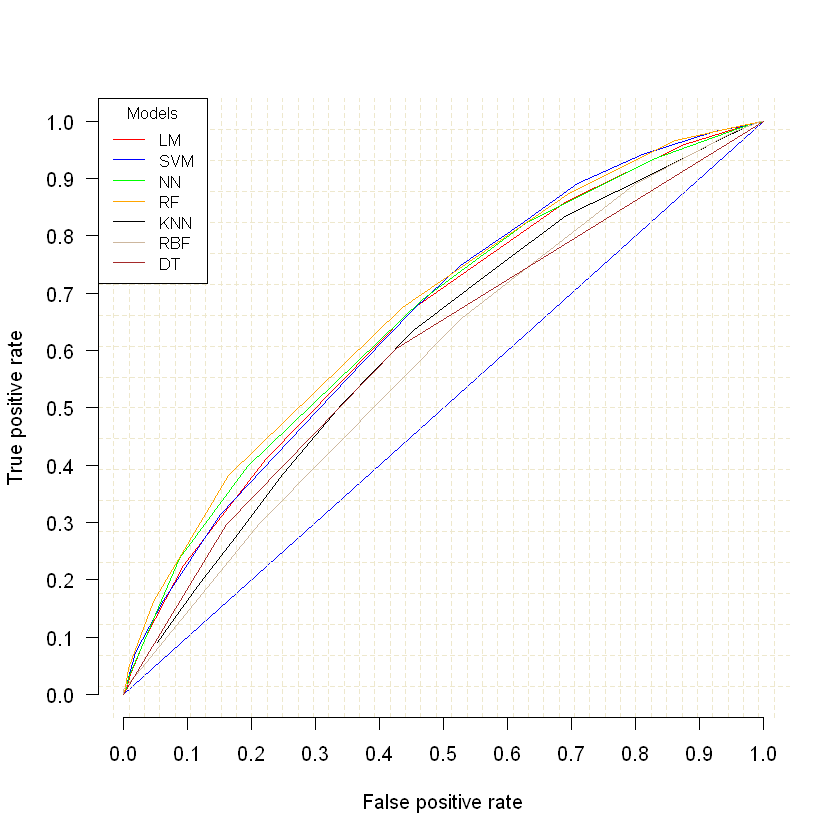

In [33]:
roc1 = compute_rocs(predictions1, Y_tests)
roc2 = compute_rocs(predictions2, Y_tests)
roc3 = compute_rocs(predictions3, Y_tests)
roc4 = compute_rocs(predictions4, Y_tests)
roc5 = compute_rocs(predictions5, Y_tests)
roc6 = compute_rocs(predictions6, Y_tests)
roc7 = compute_rocs(predictions7, Y_tests)

colors <- c("red", "blue", "green", "orange","black","bisque3","brown")

plot(c(0,1),c(0,1), type='l', xlab="False positive rate",ylab="True positive rate", col=20,axes = FALSE)+ grid (45,20, lty = 2, col = "cornsilk2")
lines(roc1$fpr, roc1$tpr,type = 'l', col=colors[1])
lines(roc2$fpr, roc2$tpr,type = 'l', col=colors[2])
lines(roc3$fpr, roc3$tpr,type = 'l', col=colors[3])
lines(roc4$fpr, roc4$tpr,type = 'l', col=colors[4])
lines(roc5$fpr, roc5$tpr,type = 'l', col=colors[5])
lines(roc6$fpr, roc6$tpr,type = 'l', col=colors[6])
lines(roc7$fpr, roc7$tpr,type = 'l', col=colors[7])
names_model = c('LM','SVM','NN','RF','KNN',"RBF","DT")
legend("topleft", legend = names_model, col=colors,  lty=1, cex=0.8, title="Models")
axis(1, at=seq(from = 0, to = 1, by = 0.1))
axis(2, at=seq(from = 0, to = 1, by = 0.1), las=1)

In [22]:
aucs <- c(AUC(unlist(roc1$fpr),unlist(roc1$tpr)),AUC(unlist(roc2$fpr),unlist(roc2$tpr)),AUC(unlist(roc3$fpr), unlist(roc3$tpr)),
         AUC(unlist(roc4$fpr), unlist(roc4$tpr)),AUC(unlist(roc5$fpr), unlist(roc5$tpr)),AUC(unlist(roc6$fpr), unlist(roc6$tpr)),
         AUC(unlist(roc7$fpr), unlist(roc7$tpr)))

AUC_matrix = matrix( aucs, nrow=1, ncol=length(aucs))
dimnames(AUC_matrix) = list(c("AUC"), c('LM','SVM','NN','RF','KNN',"RBF","DT"))
AUC_matrix

,LM,SVM,NN,RF,KNN,RBF,DT
AUC,0.6500528,0.642416,0.6576154,0.6707313,0.57574,0.5841465,0.6038247


The diagonal means that the classifier is as bad as it can be, it's not better than doing randomly the classification. The AUC is 0.5 in this case. the more the curve is far from the diagonal the better is the classifier at distinguishing between the positive and the negative class.

As expected, because of the F1 score and accuracy, the best model, according to the ROC curves, is the Random Forest, it's the model that has the biggest AUC 0.67

## Combination of models strategy

For this part of the project we need to find a strategy that combines the models in order to improve the predictive performance. The objective is reducing the variance and the bias by combining weak learners to make a strong one. There are many method that we can use, we chose three techniques : **Bagging** (Bootstrap  Aggregating), **Staking** and **Boosting** (Ada boost algorithm). 

In [24]:
# FS features
features <-FS_selected_features[1:25]
# NN parameters
size <- 2
maxIt <- 50
rang <- 0.5
# RF parameters
ntrees <- 500

### Bootstrapping Aggregating

This method consist of taking randomly from the training set (of size N) N samples with remplacement. This kind of sample is known as bootstrap sample. Each model will learn on its bootstrap sample and make predictions. Then, the final predicted value is determined by a voting process. We will use linera model, neural network and random forest which correspond to our best models.

In [27]:
# given the predictions of the different models, the predicted value is determined by voting
vote <- function(predictions) {
  uniq_predictions <- unique(na.omit(predictions))
  uniq_predictions[which.max(tabulate(match(predictions, uniq_predictions)))]
}

# bagging
bagging <- function(training_data, test_data){

    predictions <- data.frame(init=rep(0,nrow(test_data)))
    
    lm_bootstrap_samples <- training_data[sample(nrow(training_data), replace=TRUE), ]
    rf_bootstrap_samples <- training_data[sample(nrow(training_data), replace=TRUE), ]
    nnet_bootstrap_samples <- training_data[sample(nrow(training_data), replace=TRUE), ]

    # 3 bootstrap samples, one for each model
    lm_X_training <- lm_bootstrap_samples[,-ncol(lm_bootstrap_samples)]
    lm_Y_training <- lm_bootstrap_samples[,"target"]

    rf_X_training <- rf_bootstrap_samples[,-ncol(rf_bootstrap_samples)]
    rf_Y_training <- rf_bootstrap_samples[,"target"]

    nnet_X_training <- nnet_bootstrap_samples[,-ncol(nnet_bootstrap_samples)]
    nnet_Y_training <- nnet_bootstrap_samples[,"target"]
    
    # train with linear model
    lm_model <- lm(target~., cbind(lm_X_training[,features,drop=F],target=lm_Y_training))
    lm_Y_hat <- predict(lm_model,test_data)
    lm_Y_hat <- ifelse(lm_Y_hat >=0.5,1,0)

    predictions <- cbind(predictions,lm_Y_hat)

    # train with random forest
    rf_model <- randomForest(rf_X_training[,features], rf_Y_training, ntree=ntrees)
    rf_Y_hat <- predict(rf_model,test_data)
    rf_Y_hat <- ifelse(rf_Y_hat >=0.5,1,0)

    predictions <- cbind(predictions,rf_Y_hat)

    # train with neural network
    nnet_model <- nnet(target~., data=cbind(nnet_X_training[,features,drop=F],target=nnet_Y_training), trace=F,size=size,maxit=maxIt,rang=rang)
    nnet_Y_hat <- predict(nnet_model,test_data)
    nnet_Y_hat <- ifelse(nnet_Y_hat >=0.5,1,0)

    predictions <- cbind(predictions,nnet_Y_hat)
    predictions <- predictions[,-1]

    predictions <- cbind(lm_Y_hat,rf_Y_hat,nnet_Y_hat)

    final_predictions <- apply(predictions, 1, vote)
    final_predictions
}

Now that we have implemented the vote function and the bagging algorithm, we will use 10-fold cross validation in order to have an estimate of the accuracy of this strategy.

In [ ]:
samples <- cbind(X.data,target=Y.data)
accuracies <- rep(0,K)

for(i in 1:K){
    test_indexes <- which(folds==i,arr.ind=TRUE)

    training_samples <- samples[-test_indexes,]
    test_samples <- samples[test_indexes,]
    options(warn=-1)
    predictions <- bagging(training_samples, test_samples[,-ncol(test_samples)])
    
    accuracies[i] <- accuracies[i] + evaluate_classification(predictions,test_samples[,"target"])[1]
}

In [38]:
cat("Bagging accuracy : ", mean(accuracies))

Bagging accuracy :  0.6464908

We can see that there is an improvement of 0.0026 compared to the best result we had (random forest).

### Stacking

Stacking uses a similar idea to k-folds cross validation to create out-of-sample predictions. Basically, there are different models which train on the training data and make predictions. Then, all these predictions of the different models (called base models) are given as features to the meta model. The latter, trains on this predictions. The meta model will be biased towards the best of the base models.

In [ ]:
##################TRAINING##################
lm_predictions <- c()
nnet_predictions <- c()
svm_predictions <- c()

# create set of features composed by the predictions of the different base models
for(i in 1:K) {
  test_indexes <- which(folds==i,arr.ind=TRUE)

  X_test <- X.data[test_indexes,features]
  Y_test <- Y.data[test_indexes]
  X_training <- X.data[-test_indexes,features]
  Y_training<- Y.data[-test_indexes]
  
  # train and test with linear model
  lm_model <- lm(target~., cbind(X_training,target=Y_training))
  lm_Y_hat <- predict(lm_model,X_test)
  lm_Y_hat <- ifelse(lm_Y_hat >=0.5,1,0)
  
  # train and test with neural network
  nnet_model <- nnet(target~., data=cbind(X_training,target=Y_training), trace=F,size=size,maxit=maxIt,rang=rang)
  nnet_Y_hat <- predict(nnet_model,X_test)
  nnet_Y_hat <- ifelse(nnet_Y_hat >=0.5,1,0)

  # train and test with svm
  svm_model <- svm(target~.,data=cbind(X_training,target=Y_training), kernel=kernel)
  svm_Y_hat <- predict(svm_model,X_test)
  svm_Y_hat <- ifelse(svm_Y_hat >=0.5,1,0)

  lm_predictions <- c(lm_predictions,lm_Y_hat)
  nnet_predictions <- c(nnet_predictions,nnet_Y_hat)
  svm_predictions <- c(svm_predictions,svm_Y_hat)
}

learning_data <- data.frame(a=lm_predictions,b=nnet_predictions,c=svm_predictions)

# train meta model random forest
rf_model <- randomForest(cbind(X.data[,features],learning_data), Y.data, ntree=ntrees)

### Adaboost

The idea of boosting is to make a strong classifier from a number of weak classifiers. The data set is weighted and, at each learning step, missclassified points have their weight increased and good calssified points have their weights decreased.

In [ ]:
n_models <- 10

X_training <- X.data[,features,drop=F]
## Shifting the labels
Y_training <- ifelse(Y.data == 1, 1, -1)

sample_weights <- rep(1/nrow(X_training),nrow(X_training))
classifier_weights <- rep(0,n_models)

for(i in 1:n_models){

    samples <- sample(1:nrow(X_training),replace=TRUE,prob=sample_weights)

    # fit the classifier to the training data obtained by resampling X_training using weights
    lm_model <- nnet(target~., data=cbind(X_training[samples,,drop=F],target=Y_training), trace=F,size=size,maxit=maxIt,rang=rang)
    lm_Y_hat <- predict(lm_model,X_training[samples,,drop=F])
    lm_Y_hat <- ifelse(lm_Y_hat >=0.5,1,-1)
    
    predictions_weight <- data.frame(yhat=lm_Y_hat,y=Y_training[samples],weight=sample_weights[samples])
    
    # compute misclassification error on the training set
    #misclassification_error <- sum(predictions_weight[predictions_weight$yhat != predictions_weight$y,][3])/sum(sample_weights)
    misclassification_error <- sum(sample_weights*(lm_Y_hat != Y_training))/sum(sample_weights)
    
    # compute classifier weight
    classifier_weight <- log((1-misclassification_error)/misclassification_error)
    classifier_weights[i] <- classifier_weight

    # weights update
    sample_weights <- sample_weights*exp(classifier_weight*(lm_Y_hat != Y_training))
    message(classifier_weight)
    
    # normalization
    sample_weights <- sample_weights / mean(sample_weights)
}

To som up, the best strategy that we had is the bagging method which we used it in order to submit to the kaggle competition.

## Conclusion

We saw how the features selection stage is important for the learning process. The model performance, in terms of speed and accuracy can be increased a lot if the good features are selected. We compared many methods of feature selection and the one that gave us the best results was the Forward Selection. We would have liked to test those feature selection methods with differents learning models, the results would have been maybe different. 

After the feature selection, we needed to select a learning model. We executed many of them, always with a 10-fold cross validation to have a good estimation of the performances of the models.
The highest F1 score and the highest accuracy, with a cv, is given by the Random Forest with 500 trees and the top 25 features selected with the Forward Selection method.

We tried Adaboost and Staking but without any sucess. We could not find a strategy that combines the models and gives us a better score than the score we had with bagging. Finally the best result is given by the pair **Forward Selection** as a feature selection method, **Random Forest**, **Linear Model**, **Neural Network** as the learning methods and **Bagging** as the strategy.